<a href="https://colab.research.google.com/github/shumshersubashgautam/2MobileNetV2-BreastCancer/blob/master/Concentrationindex(research)valacc%3D66_69_accuracy%3D90_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd ..

/


In [2]:
cd root

/root


In [0]:
!mkdir .kaggle

In [4]:
cd .kaggle

/root/.kaggle


In [6]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shumshersubash2018","key":"3577298afccc49ea94c2161d1e3696d4"}'}

In [7]:
cd ..

/root


In [8]:
cd ..

/


In [9]:
cd content

/content


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 2.75MB/s]
 96% 88.0M/92.0M [00:00<00:00, 136MB/s]
100% 92.0M/92.0M [00:00<00:00, 157MB/s]


In [12]:
!tar -xvzf /content/fer2013.tar.gz

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [26]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split 
 
dataset_path = 'fer2013/fer2013.csv'
image_size=(48,48)

 
def load_fer2013():
    data = pd.read_csv(dataset_path)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(48, 48)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion']).as_matrix()
    return faces, emotions
 
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x
 
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [30]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import pandas as pd
import cv2
import numpy as np

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
 
# parameters
batch_size = 32
num_epochs = 110
input_shape = (224, 224, 3)
verbose = 1
num_classes = 7
patience = 50
base_path = 'models/'
l2_regularization=0.01
 
# data generator
data_generator = ImageDataGenerator(
                        preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)
 
# model parameters
regularization = l2(l2_regularization)
 
# create a copy of a mobilenet model
mobile = tensorflow.keras.applications.mobilenet.MobileNet()
mobile.summary()

# The layers are set up as a list.

type(mobile.layers)
# How many layers does MobileNet have?
len(mobile.layers)

# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 2 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)
model.summary()

# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy])    

 
# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + 'mobilenet'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.h5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]
xtrain = xtrain.reshape(-3,224, 224, 3)   #Reshape for CNN -  should work!!
xtest = xtest.reshape(-3,224, 224, 3)
ytrain = ytrain.reshape(-3,224, 224, 3)   #Reshape for CNN -  should work!!
ytest = ytest.reshape(-3,224, 224, 3)

 
model.fit_generator(data_generator.flow(xtrain, ytrain, batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))


Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

ValueError: ignored

In [37]:
'''
This script creates 3-channel gray images from FER 2013 dataset.
It has been done so that the CNNs designed for RGB images can 
be used without modifying the input shape. 
This script requires two command line parameters:
1. The path to the CSV file
2. The output directory
It generates the images and saves them in three directories inside 
the output directory - Training, PublicTest, and PrivateTest. 
These are the three original splits in the dataset. 
'''

import os
import csv
import argparse
import numpy as np 
import scipy.misc

parser = argparse.ArgumentParser()
parser.add_argument('-f', '--/content/fer2013/fer2013.csv', required=True, help="path of the csv file")
parser.add_argument('-o-', '/content/', required=True, help="path of the output directory")
args = parser.parse_args()

w, h = 48, 48
image = np.zeros((h, w), dtype=np.uint8)
id = 1

with open(args.file) as csvfile:
    datareader = csv.reader(csvfile, delimiter =',')
    next(datareader,None)
	
    for row in datareader:
        
        emotion = row[0]
        pixels = row[1].split()
        usage = row[2]
        pixels_array = np.asarray(pixels, dtype=np.int)

        image = pixels_array.reshape(w, h)
        #print image.shape

        stacked_image = np.dstack((image,) * 3)
        #print stacked_image.shape

        image_folder = os.path.join(args.output, usage)
        if not os.path.exists(image_folder):
            os.makedirs(image_folder)
        image_file =  os.path.join(image_folder , str(id)+'_'+emotion+'.jpg')
        scipy.misc.imsave(image_file, stacked_image)
        id += 1 
        if id % 100 == 0:
            print('Processed {} images'.format(id))

print("Finished processing {} images".format(id))

ValueError: ignored

In [0]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# Imports
import cv2
import numpy as np
import os
import sys

def main():
    # Message Error
    if len(sys.argv) < 2:
        print ('\nUsage: python convert-csv.py [output_path]\n')

    return -1

    output_path = sys.argv[1]

    if os.path.exists(output_path):
        os.system('rm -rf {}'.format(output_path))

    os.system('mkdir {}'.format(output_path))

    # Label names 
    label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    # Importing dataset with np.genfromtxt()
    data = np.genfromtxt('/content/fer2013/fer2013.csv', delimiter=',', dtype=None )

    labels = data[1:,0].astype(np.int32)

    image_buffer = data[1:,1]

    images = np.array([np.fromstring(image, np.uint8, sep=' ') for image in image_buffer])

    usage = data[1:,2]

    dataset = zip(labels, images, usage)

    for i, d in enumerate(dataset):
        usage_path = os.path.join(output_path, d[-1])
        label_path = os.path.join(usage_path, label_names[d[0]])

        # We know that the size of the images of the FER-2013 are 48x48
        img = d[3].reshape((224, 224))

        image_name = '%08d.jpg' % i

        image_path = os.path.join(label_path, image_name)

        if not os.path.exists(usage_path):
            os.system('mkdir {}'.format(usage_path))

        if not os.path.exists(label_path):
            os.system('mkdir {}'.format(label_path))

        cv2.imwrite(image_path, img)
        print ('Write {}'.format(image_path))

if __name__ == '__main__': main()

In [0]:

import numpy as np
import pandas as pd

In [0]:
train_csv = pd.read_csv('/content/fer2013/fer2013.csv')

In [33]:
train_csv.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [37]:
train_csv.groupby('emotion').count()

,pixels,Usage
emotion,,
0,4953,4953
1,547,547
2,5121,5121
3,8989,8989
4,6077,6077
5,4002,4002
6,6198,6198


In [44]:

train_csv.groupby('emotion').count()

,pixels,Usage
emotion,,
0,4953,4953
1,547,547
2,5121,5121
3,8989,8989
4,6077,6077
5,4002,4002
6,6198,6198


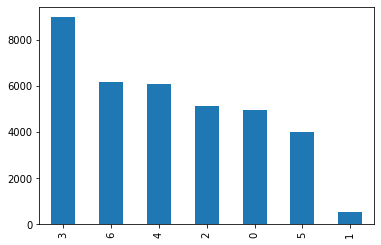

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

train_csv['emotion'].value_counts().plot(kind='bar')

In [46]:
train_csv.replace("contempt", "anger", inplace=True)
train_csv.groupby('emotion').count()

,pixels,Usage
emotion,,
0,4953,4953
1,547,547
2,5121,5121
3,8989,8989
4,6077,6077
5,4002,4002
6,6198,6198


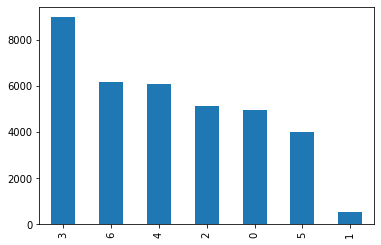

In [47]:
train_csv['emotion'].value_counts().plot(kind='bar')

In [0]:
mapping_emotion = {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'neutral': 6, 'sadness': 4, 'surprise': 5}
train_csv['label'] = train_csv['emotion'].map(mapping_emotion)

In [49]:
train_csv.head()

,emotion,pixels,Usage,label
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,NaN
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,NaN
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,NaN
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,NaN
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,NaN


In [0]:
import cv2 as cv
# Load image 
img_1 = cv.imread('/content/2519759-kg.jpg')

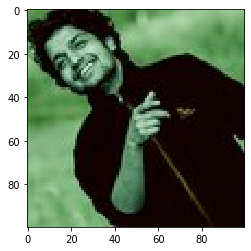

In [51]:
plt.imshow(img_1,cmap='gray')

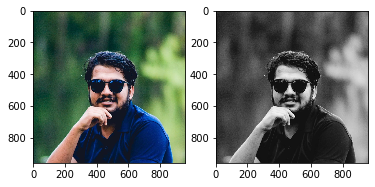

In [52]:
img_colored = cv.imread('/content/41341820_312990716132260_8149820213618016256_n.jpg')
#plt.imshow(cv2.cvtColor(img_colored, cv2.COLOR_BGR2RGB))

gray_image = cv.cvtColor(img_colored, cv.COLOR_BGR2GRAY) 
#plt.imshow(gray_image,cmap='gray')

plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img_colored, cv.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(gray_image,cmap='gray')

In [53]:
!git clone https://github.com/opencv/opencv.git

Cloning into 'opencv'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 264081 (delta 0), reused 3 (delta 0), pack-reused 264060
Receiving objects: 100% (264081/264081), 464.64 MiB | 27.55 MiB/s, done.
Resolving deltas: 100% (184096/184096), done.
Checking out files: 100% (6119/6119), done.


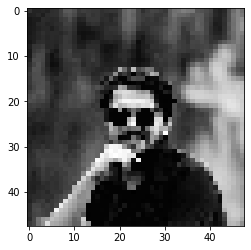

In [54]:
face_cascade = cv.CascadeClassifier('/content/opencv/data/haarcascades/haarcascade_frontalface_default.xml')
height, width = gray_image.shape[:2]
face = face_cascade.detectMultiScale(gray_image, 1.3, 1)
if isinstance(face, tuple):
    resized_image = cv.resize(gray_image, (48,48))
        #cv.imwrite(trained+'/'+name,resized_image)
elif isinstance(face, np.ndarray):
    for (x,y,w,h) in face:
        if w * h < (height * width) / 3:
            resized_image = cv.resize(gray_image, (48,48)) 
                #cv.imwrite(trained+'/'+name,resized_image)
        else:
            roi_gray = gray_image[y:y+h, x:x+w]
            resized_image = cv.resize(roi_gray, (48,48))
                #cv.imwrite(trained+'/'+name, resized_image)
    #if not name in deleting:
    #data1.append(img_to_array(resized_image))
plt.imshow(resized_image,cmap='gray')

In [0]:
import glob
import cv2 as cv
import os
from keras.preprocessing.image import img_to_array

In [0]:
trained = 'trainedimages'
os.mkdir(trained)

In [0]:
face_cascade = cv.CascadeClassifier('/content/opencv/data/haarcascades/haarcascade_frontalface_default.xml')
image_train = '../input/dataset/dataset/images'

In [62]:
!git clone https://github.com/gitshanks/fer2013.git

Cloning into 'fer2013'...
remote: Enumerating objects: 152, done.
remote: Total 152 (delta 0), reused 0 (delta 0), pack-reused 152
Receiving objects: 100% (152/152), 22.46 MiB | 29.67 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [58]:
cd ..

/


In [59]:
cd content

/content


In [0]:
!mkdir her

In [61]:
cd her

/content/her


In [65]:
!python /content/her/fer2013/fertrain.py

Using TensorFlow backend.






2019-12-03 16:50:53.582102: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-12-03 16:50:53.582462: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2b74bc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-03 16:50:53.582502: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-12-03 16:50:53.584958: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-12-03 16:50:53.641677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-12-03 16:50:53.642681: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2b74d80 initialized for platform CUDA (this does not guarantee that XLA will be use

In [64]:
!python /content/her/fer2013/preprocessing.py

Preprocessing Done
Number of Features: 48
Number of Labels: 7
Number of examples in dataset:35887
X,y stored in fdataX.npy and flabels.npy respectively
